# Scopo del notebook: allenare la rete neurale su Car Brand Logos

#### Costanti

In [1]:
# dimensione del batch
BATCH_SIZE = 8
# n° di epoche del training
NUM_OF_EPOCHS = 100

# definisce se usare augmentation nel training set
USE_AUG = True
# definisce se loggare i dati in Tensorboard
log_to_tb = False
# definisce se usare la ResNet18 (true) o LeNet5 (false)
using_res = True
# nome del file .pth che conterrà la rete allenata e l'eventuale cartella di tensorboard
NET_NAME = 'resnet50_aug'

#### Percorsi di salvataggio

In [2]:
SAVE_PATH = 'trained/' + NET_NAME + '.pth'
SAVE_PATH2 = 'trained/' + NET_NAME + '_best.pth'
RUNS_PATH = 'runs/' + NET_NAME

#### Percorso dove trovare train e test set

In [3]:
train_path = 'data/car_brand_logos/Train/'
test_path = 'data/car_brand_logos/Test/'

## Data analysis: Car Brand Logos

### Train set

| Label name | | Number of images |
| - | | - | 
| hyundai | | 302 | 
| lexus | | 301 | 
| mazda | | 316 | 
| mercedes | | 342 | 
| opel | | 301 | 
| skoda | | 314 | 
| toyota | | 306 | 
| volkswagen | | 330 | 

### Test set
| Label name | | Number of images |
| - | | - | 
| hyundai | | 50 | 
| lexus | | 50 | 
| mazda | | 50 | 
| mercedes | | 50 | 
| opel | | 50 | 
| skoda | | 50 | 
| toyota | | 50 | 
| volkswagen | | 50 | 

### Imports

In [4]:
import torch, torchvision
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Resize, ToPILImage, CenterCrop, Normalize, Compose
from torchvision.transforms.functional import to_grayscale, to_tensor, rotate, hflip, affine, adjust_brightness
import matplotlib.pyplot as plt

import os
import random
import pandas as pd
from torchvision.io import read_image

from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from sklearn.metrics import classification_report, confusion_matrix

from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
import seaborn as sn
import numpy as np

import io
from PIL import Image
from PIL.features import pilinfo

import traceback
import warnings
warnings.filterwarnings("error")

import imgaug.augmenters as iaa

### Funzioni per recuperare i dati

 - getLabelList(percorso del dataset): ritorna una Series costituita da indice numerico a cui associa l'immagine (nome) e la sua label (valore numerico)
 - getImgPool(percorso del dataset): ritorna una Series costituita da indice numerico a cui associa il percorso assoluto dell'immagine, la label (valore numerico) e la corrisponde classe (stringa)

In [5]:
def getLabelList(path):
    only_dirs = [ name for name in os.listdir(path) if 
                 os.path.isdir(os.path.join(path, name)) ]
    only_dirs.sort()
    ret = {}
    index = 0
    
    for d in only_dirs:
        new_path = path + d
        label = only_dirs.index(d)
        for img in [ name for name in os.listdir(new_path) ]:
            ret[index] = [img, label]
            index += 1
    
    return pd.Series(ret)

In [6]:
def getImgPool(path):
    only_dirs = [ name for name in os.listdir(path) if 
                 os.path.isdir(os.path.join(path, name)) ]
    only_dirs.sort()
    ret = {}
    index = 0
    
    for d in only_dirs:
        new_path = path + d
        label = only_dirs.index(d)
        for img in [ name for name in os.listdir(new_path) ]:
            abs_path = new_path + '/' + img
            ret[index] = [abs_path, label, d]
            index += 1
    
    return pd.Series(ret)

#### Funzione per convertire le immagini di formato diverso
data un'immagine diversa dalle JPG (WEBP o PNG in questo dataset) le codifica in jpg

In [7]:
# convert a given format image hidden in JPG format, converting it to a JPG and overwriting the original with its format (WEBP or PNG)

def convertPNGImage(path, start_format):
    img = Image.open(path, formats=[start_format])
    new_path = path[:-3] + 'jpg'
    img.convert('RGB').save(new_path)
    image = Image.open(new_path, formats=['JPEG'])
    return image    

## Creazione della struttura dataset (contenitore di immagini)

### LeNet5
Caratteristiche: immagini in bianco e nero, augmentation usate: rotazione e specchiamento asse y

In [8]:
if not using_res:
    class CustomImageDataset(Dataset):
        def __init__(self, path_labels, transform=None, target_transform=None, use_aug=True):
            self.img_labels = getLabelList(path_labels)
            self.images = getImgPool(path_labels)
            self.transform = transform
            self.target_transform = target_transform
            self.use_aug = use_aug

        def __len__(self):
            return len(self.img_labels)

        def __getitem__(self, idx):
            try: 
                image = Image.open(self.images.loc[idx][0])
                if Image.MIME[image.format] == 'image/webp': #formato errato
                        image = convertPNGImage(self.images.loc[idx][0], 'WEBP')
            except Exception:
                print('Found error at {} in position {}'.format(self.images.loc[idx][0], idx))
            image = ToTensor()(image)
            
            if image.shape[0] >= 3: #trasformo l'immagine in bianco e nero
                image = to_tensor(to_grayscale(ToPILImage()(image), num_output_channels=1))
            else: #già in bianco e nero, converto al Tensor 
                image = to_tensor(ToPILImage()(image))

            image = Resize((300, 300))(image)
            
            #parte di data augmentation
            if self.use_aug:
                fr = random.choices([0,1],[0.2,0.8])[0] # rotazione (80% probabilità di capitare)
                if fr == 1: 
                    angle = torch.randint(40, size=(1,)).item() - 20 
                    image = rotate(image, angle)

                fr = random.choices([0,1],[0.5,0.5])[0] # specchiamento asse y (80% probabilità di capitare)
                if fr == 1: 
                    image = hflip(image)
            label = self.img_labels.loc[idx][1]

            return image, label

### ResNet18
Caratteristiche: immagini a colori, augmentation usate: cambio luminosità, rotazione, 
specchiamento asse y, traslazione su entrambi gli assi tra 100 e -100px, rumore gaussiano

In [219]:
if using_res:
    class CustomImageDataset(Dataset):
        def __init__(self, path_labels, transform=None, target_transform=None, use_aug=True):
            self.img_labels = getLabelList(path_labels)
            self.images = getImgPool(path_labels)
            self.transform = transform
            self.target_transform = target_transform
            self.use_aug = use_aug

        def __len__(self):
            return len(self.img_labels)

        def __getitem__(self, idx):
            try: 
                image = Image.open(self.images.loc[idx][0])
                if Image.MIME[image.format] == 'image/png': #formato errato
                        image = convertPNGImage(self.images.loc[idx][0], 'PNG')
            except Exception:
                print('Found error at {} in position {}'.format(self.images.loc[idx][0], idx))
                
            image = ToTensor()(image)
            
            if image.shape[0] != 3: #converto le immagini in bianco e nero e RGBA in RGB
                image = ToPILImage()(image).convert('RGB')  
            else: #immagine già RGB
                image = ToPILImage()(image)
                
            preprocess = Compose([
                Resize(300),
                CenterCrop(300),
                ToTensor(),
            ])
            image = preprocess(image)
            
            #parte di data augmentation
            if self.use_aug:
                im_np = np.array((image*255).permute(1,2,0), dtype='uint8')

                # augmentations
                bright = iaa.AddToBrightness((-50,50))
                rotate = iaa.Rotate((-20, 20))
                hflip = iaa.Fliplr(0.5)
                tr_x = iaa.TranslateX(px=(-100, 100))
                tr_y = iaa.TranslateY(px=(-100, 100))
                gauss = iaa.imgcorruptlike.GaussianNoise(severity=1)
                blend = iaa.BlendAlphaHorizontalLinearGradient(iaa.AddToHue((-100, 100)))
                drop_channel = iaa.Dropout2d(p=0.5)
                mult = iaa.Multiply((0.5, 1.5), per_channel=0.5)

                seq = iaa.Sequential([
                    iaa.Sometimes(0.5, bright),
                    iaa.Sometimes(0.8, rotate),
                    iaa.Sometimes(0.5, hflip),
                    iaa.Sometimes(0.5, tr_x),
                    iaa.Sometimes(0.5, tr_y),
                    iaa.Sometimes(0.5, gauss),
                    iaa.Sometimes(0.5, blend),
                    iaa.Sometimes(0.5, drop_channel),
                    iaa.Sometimes(0.5, mult)                    
                ])

                img = seq(image=im_np)
                image = to_tensor(img)
                
                
            
            preprocess2 = Compose([ # secondo preprocess dell'immagine per evitare problemi con il cambio luminosità
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
            image = preprocess2(image)
            
            label = self.img_labels.loc[idx][1]

            return image, label

### Creazione dei 2 dataset

In [220]:
train_data = CustomImageDataset(path_labels=train_path, transform=ToTensor(), target_transform=ToTensor(), use_aug=USE_AUG)
test_data = CustomImageDataset(path_labels=test_path, transform=ToTensor(), target_transform=ToTensor(), use_aug=False)

print (f'N° immagini nel train dataset: {train_data.__len__()}')
print (f'N° immagini nel test dataset: {test_data.__len__()}')

N° immagini nel train dataset: 2512
N° immagini nel test dataset: 400


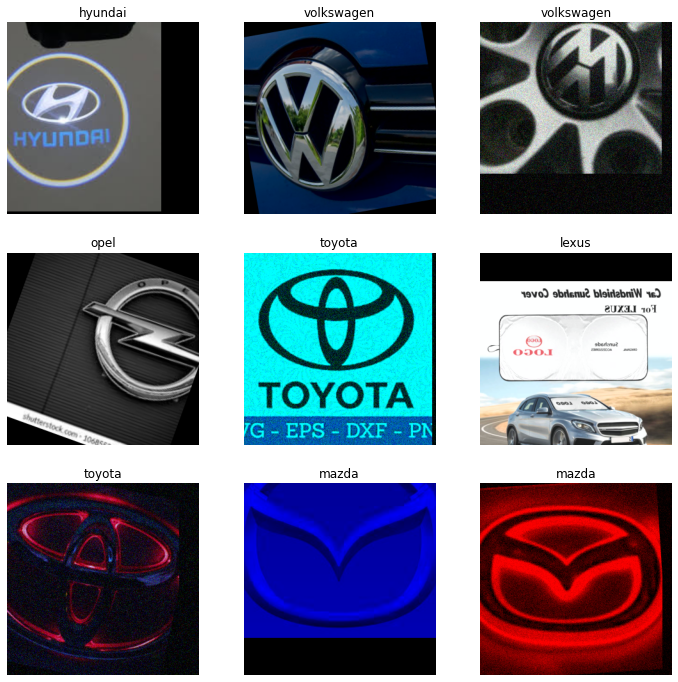

In [221]:
#verifica caricamento delle immagini
only_dirs = [ name for name in os.listdir(train_path) if 
                 os.path.isdir(os.path.join(train_path, name)) ]

diz = {}
nocl=0 # numero di classi
for d in only_dirs:
    diz[nocl] = d
    nocl+=1

figure = plt.figure(figsize=(12, 12))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item() 
    img, label = train_data[sample_idx]
    if using_res: # rimuovo effetti normalizzazione (cattiva visualizzazione delle immagini)
        img = img * torch.tensor([0.229, 0.224, 0.225]).reshape(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).reshape(3,1,1)
    img = torch.clamp(img, 0, 1) # rimuovo effetti rumore gaussiano
    
    figure.add_subplot(rows, cols, i)
    plt.title(diz[label])
    plt.axis("off")
    if not using_res:
        plt.imshow(img.squeeze(), cmap='gray') # visualizzazione lenet
    else:
        plt.imshow(img.permute(1,2,0)) # visualizzazione resnet
plt.show()

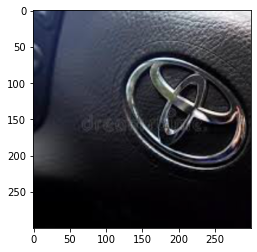

In [194]:
sample_idx = torch.randint(len(train_data), size=(1,)).item() 
image = train_data[sample_idx][0]
if using_res:
        image = image * torch.tensor([0.229, 0.224, 0.225]).reshape(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).reshape(3,1,1)
plt.imshow(image.permute(1,2,0))

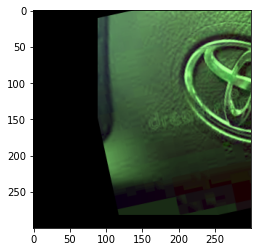

In [218]:
im_np = np.array((image*255).permute(1,2,0), dtype='uint8')
                
# augmentations
bright = iaa.AddToBrightness((-50,50))
rotate = iaa.Rotate((-20, 20))
hflip = iaa.Fliplr(0.5)
tr_x = iaa.TranslateX(px=(-100, 100))
tr_y = iaa.TranslateY(px=(-100, 100))
gauss = iaa.imgcorruptlike.GaussianNoise(severity=1)
blend = iaa.BlendAlphaHorizontalLinearGradient(iaa.AddToHue((-100, 100)))
drop_channel = iaa.Dropout2d(p=0.5)
mult = iaa.Multiply((0.5, 1.5), per_channel=0.5)

seq = iaa.Sequential([
    iaa.Sometimes(0.5, bright),
    iaa.Sometimes(0.8, rotate),
    iaa.Sometimes(0.5, hflip),
    iaa.Sometimes(0.5, tr_x),
    iaa.Sometimes(0.5, tr_y),
    iaa.Sometimes(0.5, gauss),
    iaa.Sometimes(0.5, blend),
    iaa.Sometimes(0.5, drop_channel),
    iaa.Sometimes(0.5, mult)                    
])

img = seq(image=im_np)

plt.imshow(img)

## Creazione dataloader (richiede immagini al dataset, producendo i batch)


In [ ]:
train_dl = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_dl = DataLoader(test_data, batch_size=8, shuffle=True)

In [ ]:
#dataloader test
images, labels = next(iter(train_dl)) #prendo un batch
print(f"Feature batch shape: {images.size()}")
print(f"Labels batch shape: {labels.size()}")
# prendo prima immagine e label dal batch
img = images[0]
label = labels[0]
if not using_res:
    plt.imshow(img.squeeze(), cmap='gray')
else:
    img = img * torch.tensor([0.229, 0.224, 0.225]).reshape(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).reshape(3,1,1)
    img = torch.clamp(img, 0, 1)
    plt.imshow(img.permute(1,2,0))
plt.show()
print(f"Classe: {diz[label.item()]}")

### Esempio augmentation

In [ ]:
images, labels = next(iter(test_dl)) #prendo un batch dal test siccome non uso augmentation lì
image = images[0]
N_ROWS = 1
if using_res:
    N_ROWS = 2

fig, axs = plt.subplots(figsize=(16,8), nrows=N_ROWS, ncols=3)
if using_res:
    image = image * torch.tensor([0.229, 0.224, 0.225]).reshape(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).reshape(3,1,1)

    
img=image
axs[0][0].imshow(img.permute(1,2,0))
axs[0][0].set_title('immagine originale')
axs[0][0].axis('off')

#applico rotazione
angle = torch.randint(40, size=(1,)).item() - 20
img = rotate(img, angle)
axs[0][1].imshow(img.permute(1,2,0))
axs[0][1].set_title('rotation (of {} degrees)'.format(angle))
axs[0][1].axis('off')

#applico specchiamento
img = image
img = hflip(img)
axs[0][2].imshow(img.permute(1,2,0))
axs[0][2].set_title('horizontal flip')
axs[0][2].axis('off')
if using_res:
    #applico rumore
    img = image
    gauss_noise = np.random.normal(0, 0.4, (img.shape[1], img.shape[2]))
    img = img + gauss_noise
    img = torch.clamp(img, 0, 1)
    axs[1][0].imshow(img.permute(1,2,0))
    axs[1][0].set_title('gaussian noise')
    axs[1][0].axis('off')

    # cambio luminosità (1 valore base, vado ad aumentare/diminuire a caso con un limite di 0,5)
    img = image
    num = 0.5 + random.random()
    img = adjust_brightness(img, num)
    axs[1][1].imshow(img.permute(1,2,0))
    axs[1][1].set_title(f"change in brightness (of {int(num*100) - 100}%)")
    axs[1][1].axis('off')

    # applico traslazione (tra -100, 100px su entrambi gli assi)
    img = image
    trX = torch.randint(200, size=(1,)).item() - 100
    trY = torch.randint(200, size=(1,)).item() - 100
    img = affine(img, angle=0, translate=(trX, trY), scale=1, shear=0)
    axs[1][2].imshow(img.permute(1,2,0))
    axs[1][2].set_title(f"translation of ({trX},{-trY})")
    axs[1][2].axis('off')

    plt.show()

## Definizione architettura della rete neurale

In [ ]:
print("GPU compute available: ", torch.cuda.is_available())


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

### LeNet5

In [ ]:
if not using_res:
    class Net(nn.Module):

        def __init__(self):
            super(Net, self).__init__()
            self.conv1 = nn.Conv2d(1, 6, 5)  # 1 indica il numero di canali dell'immagine (1 - bianco e nero)
                                             # 6 indica i canali di uscita
                                             # 5 indica la dimensione del filtro
                                             # DEFAULT: passo = 1, padding = 0
            self.pool = nn.MaxPool2d(2, 2) # finestra di pooling grande 2x2 (quindi dimezza altezza e larghezza dell'immagine)
            self.conv2 = nn.Conv2d(6, 16, 5)        
            self.fc_layer1 = nn.Linear(16 * 72 * 72, 120)        
            self.fc_layer2 = nn.Linear(120, 84)
            self.fc_layer3 = nn.Linear(84, nocl) # nocl indica il numero di classi (8 qui)
            
        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = torch.flatten(x, 1)
            x = F.relu(self.fc_layer1(x))
            x = F.relu(self.fc_layer2(x))
            x = self.fc_layer3(x)
            return x
        
    net = Net()
    net.to(device)

### ResNet18

In [ ]:
if using_res:
    net = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
    net.fc = torch.nn.Linear(2048, 8)
    net.to(device)

In [ ]:
#test struttura rete
params = list(net.parameters())
print(len(params))
print(params[0].size())  # verifico che il primo layer convolutivo sia stato costruito/caricato

#### Loss function e gradiente

In [ ]:
# loss function
criterion = nn.CrossEntropyLoss()
# uso stochastic gradient descent
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_OF_EPOCHS)

## Configurazione Tensorboard

In [ ]:
if log_to_tb:
    writer = SummaryWriter(RUNS_PATH) # creo il logger dei dati

    # aggiunta di immagini casuali al tensorboard
    dataiter = iter(train_dl)
    images, labels = dataiter.next()

    for idx in range(4):    
        img = images[idx]
        if using_res:
            img = img * torch.tensor([0.229, 0.224, 0.225]).reshape(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).reshape(3,1,1)
        img = torch.clamp(img, 0, 1)
        writer.add_image(f"car_brands_images_{idx+1}", img)

    # aggiunta dello schema della rete 
    images = images.to(torch.float32)
    writer.add_graph(net, images.to(device))

    # aggiunta del projector 
    tmp_dl = DataLoader(train_data, batch_size=100, shuffle=True) #prendo 100 immagini
    images, labels = next(iter(tmp_dl))
    class_labels = [diz[lab.item()] for lab in labels]
    
    images = Resize((28, 28))(images) 
    # adattamento della shape del tensor a [100, dimensione immagine]
    if using_res:
        features = images.view(100, 3 * 28 * 28) 
    else:
        features = images.view(-1, 28 * 28)
    writer.add_embedding(features,
                        metadata=class_labels,
                        label_img=images)

## Addestramento della rete

In [ ]:
print(next(net.parameters()).device)

In [ ]:
best_accuracy = 0
for epoch in range(NUM_OF_EPOCHS):  # ciclo sul dataset
    net.train()
    running_loss = 0.0
    for i, data in enumerate(train_dl):
        # prelevo immagini e label dal dataloader, poi le adatto
        inputs, labels = data
        batch_len = len(labels)
        inputs = inputs.to(device)
        inputs = inputs.to(torch.float32)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs) # processo immagini, ottenendo predizioni
        loss = criterion(outputs, labels) # calcolo loss
        loss.backward() # backpropagation
        optimizer.step()

        running_loss += loss.item()
        skip = 50
        if i > 0  and i % skip == 0:    # stampa training loss ogni 50 * dimensione batch (50*8 qui)
            print(f'[{epoch + 1}, {i}/{len(train_dl)}] loss: {(running_loss/skip):.3f}')
            # salvataggio della train loss in tensorboard
            if log_to_tb:
                writer.add_scalar('training loss',
                               running_loss / skip,
                               (epoch * len(train_data)) + (i * batch_len))
            running_loss = 0.0
    scheduler.step()

    # fine di un'epoca, calcolo test loss e accuratezza (siccome qui il test dataset è piccolo)
    with torch.no_grad():
        net.eval()
        test_loss = 0
        test_acc = 0
        test_total = 0
        for _, data in enumerate(test_dl):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0) 
            test_acc += (predicted == labels).sum().item() 
            
        actual_test_loss = test_loss/len(test_dl)
        accuracy = (100 * test_acc / test_total)
        
        # print(f"[{epoch + 1}] test loss: {(actual_test_loss):.3f} , test acc: {accuracy}")
        summary = f"[{epoch + 1}] test loss: {(actual_test_loss):.3f} , test acc: {accuracy}\n"
        with open('metrics.txt', 'a') as f:
            f.write(summary)
        print(summary)
        if log_to_tb: # salvataggio test loss e accuratezza in tensorboard
            writer.add_scalar('test loss',
                           actual_test_loss,
                           epoch+1)
            writer.add_scalar('accuracy',
                           accuracy,
                           epoch+1)

        # se l'accuratezza migliora, salvo il modello (migliore rispetto a prima)
        if accuracy > best_accuracy:
           best_accuracy = accuracy
           torch.save(net.state_dict(), SAVE_PATH2)
        

print('Fine Addestramento')
print(f"Miglior acc: {best_accuracy:.5f}")

In [ ]:
#salvo il modello prodotto alla 25a epoca
torch.save(net.state_dict(), SAVE_PATH)

#### test modello salvato

In [ ]:
if not using_res:
    loaded = Net()
else:
    loaded = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
    
loaded.load_state_dict(torch.load(SAVE_PATH2))
loaded.to(device)
loaded.eval()

In [ ]:
# salvataggio precision and recall curve (metrica per testare la bontà di un modello, basata sulla matrice di confusione della classe)
def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(diz[class_index],
                        tensorboard_truth,
                        tensorboard_probs,
                        global_step=global_step)

if log_to_tb:
    class_probs = []
    class_label = []
    with torch.no_grad():
        for data in test_dl:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            output = loaded(images)
            class_probs_batch = [F.softmax(el, dim=0) for el in output]

            class_probs.append(class_probs_batch)
            class_label.append(labels)

    test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
    test_label = torch.cat(class_label)

    # plot all the pr curves
    for i in range(len(diz.values())):
       add_pr_curve_tensorboard(i, test_probs, test_label)